# Correlation and linear models

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df = pd.read_csv('../data/boston_precip_temp.csv')
df.head()


,station,name,date,temp,diurnal_temp_range,precip-total,snow-totals
0,USW00054704,"NORWOOD MEMORIAL AIRPORT, MA US",1,25.9,19.7,3.43,NaN
1,USW00054704,"NORWOOD MEMORIAL AIRPORT, MA US",2,28.9,21.0,3.25,NaN
2,USW00054704,"NORWOOD MEMORIAL AIRPORT, MA US",3,36.4,21.5,4.45,NaN
3,USW00054704,"NORWOOD MEMORIAL AIRPORT, MA US",4,46.8,22.7,4.19,NaN
4,USW00054704,"NORWOOD MEMORIAL AIRPORT, MA US",5,56.4,24.9,3.68,NaN


## Correlation
Often in data analysis, we want to determine if there is a relationship between two values. Using a scatter plot with each variable on an axis is a great way to do a qualitative first pass at this. You can then see if one value increases with the other one, or if one decreases when the other increases.

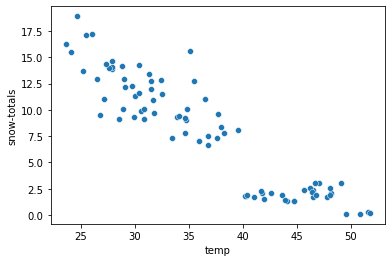

In [80]:
df_sub = df.loc[(df['snow-totals']>0) & (df['snow-totals'].notnull()) & (df['temp'].notnull()),:].reset_index(drop=True)

sns.scatterplot(data=df_sub, x='temp', y='snow-totals' )
plt.show()

Scipy has a function called `pearsonr()` that calculates correlation between a pair of variables. It also calculates a p-value, which is the probability of seeing a correlation this extreme if the true correlation is zero. 

The documentation does note that the p-values are not super reliable for sample sizes below 500. 

In [81]:
stats.pearsonr(df_sub['temp'], df_sub['snow-totals'])

(-0.919683409455466, 3.2050464492624835e-34)

You can also calculate correlation values between all possible pairs of numerical variables and display these in a matrix plot using a method built into pandas data frames called `corr()`.

In [82]:
df_sub.corr()

,date,temp,diurnal_temp_range,precip-total,snow-totals
date,1.000000,0.354837,-0.177822,0.322120,-0.467552
temp,0.354837,1.000000,0.213018,0.485798,-0.919683
diurnal_temp_range,-0.177822,0.213018,1.000000,0.117884,-0.206205
precip-total,0.322120,0.485798,0.117884,1.000000,-0.338424
snow-totals,-0.467552,-0.919683,-0.206205,-0.338424,1.000000


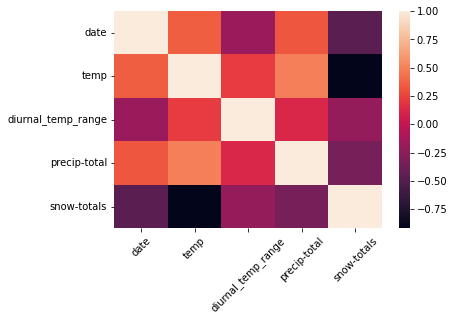

In [83]:
correlations = df_sub.corr()

sns.heatmap(correlations)
plt.xticks(rotation=45)
plt.show()

### Question

Load in the gapminder data set. Calculate correlations between the numerical variables. Which are highly positively correlated? Which are highly negatively correlated?

In [84]:
gap = pd.read_csv('../data/gapminder.csv')

## your code here

## Linear regression
We can further quantify the relationship between two variables by using linear regression. At its simplest, linear regression tries to find a line that fits our data the closest. Essentially, we want our line to be as close as possible to all points. 

You may remember that a line in algebra has the equation $y = mx + b$. In linear regression, we are trying to construct a line with essentially that same formula. In linear regression, $y$ is called the dependent variable, and it is typically the value we are trying to predict. We try to predict the value using $x$, the independent variable. We call $y$ the dependent variable because in our equation, its value depends on $x$. 

In the equation of a line above, $m$ is the slope of the line. In linear regression, we label the slope as $\beta_1$ instead of $m$, and we call it the regression coefficient. When we increase $x$ by 1 unit, the amount that y changes will depend on the size and sign of $\beta_1$. 

Similarly, $b$ is the intercept, or where the line crosses the $y$ intercept. In linear regression, this is still sometimes referred to as the intercept coefficient, and we label it as $\beta_0$ . It represents the prediction for $y$ when $x$ is zero.

Therefore, the line we make in linear regression has the formula:

$$y = \beta_0+\beta_1x$$

Linear regression uses an algorithm called ordinary least squares to find the best values of $\beta_0$ and $\beta_1$ for your variables. This process results in a linear model, and the process is called fitting a linear model. 

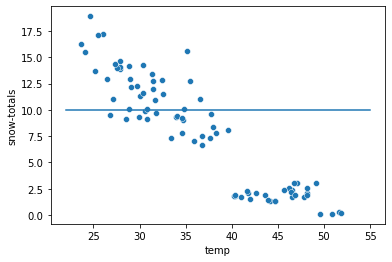

In [85]:
b0 = 10
b1 = 0

x = np.linspace(22, 55, 1000)
y = b0 + x*b1 

sns.scatterplot(data=df_sub, x='temp', y='snow-totals' )
sns.lineplot(x=x, y=y)
plt.show()

### Question
Be your own linear regression! Change `b0` and `b1` to get them to match the relationship of the data as closely as possible. 

statsmodels is another python library with statistical tools. It has great tools for running linear regressions.

Specifically, we're going to use the submodule `statsmoduls.formula.api`.

Within this module we will use the `ols()` function, which takes in two primary parameters: `formula`, and `data`. The data is your pandas data frame. 

`formula` essentially lets you tell the model which columns are the dependent and independent variables. The column name on left will be the dependent variable ($y$), the variable we are trying to predict, and the one the right is the independent variables ($x$), our predictor. 

We separate the two with a `~`, which you can kind of think of as the equal sign in the equation.

Make sure the formula is all in quotes! Additionally, if the column names have certain characters, like dashes or spaces, statsmodels doesn't like this, and we have to specify `Q("colname")`.

**Make sure to run `.fit()` on the model to actually run the regression.**


In [71]:
import statsmodels.formula.api as smf
model = smf.ols(formula='Q("snow-totals") ~ temp',data=df_sub).fit()

It can be easier to get around this by just changing the column names. 

In [72]:
df_sub1 = df_sub.rename(columns={'precip-total':'precip_total'	,'snow-totals':'snow_total'})
model = smf.ols(formula='snow_total ~ temp',data=df_sub1).fit()

### Residuals
Linear regression uses values of $x$ to predict $y$ using the model we have just fit. However, the predicted values from the model are not always correct. The differences between the predictions from the model and the actual values are called residuals. It's important that residuals have certain qualities, as discussed below.  

Residuals that are positive means that the prediction from the line is too low, and residuals that are negative means the prediction was too high.

![model residuals](https://dfrrh0itwp1ti.cloudfront.net/img/a/probability-and-statistics/regression/residual/residual.png)

Ordinary least squares (OLS) tries to minimize these residuals. Specifically, it minimizes the square of the residuals, since residuals can have negative values. 

### Diagnostic plots
Linear regression is a great tool for evaluating relationships between variables, but it may not always be appropriate for your data. It makes several assumptions about your data, and if these assumptions are not met, linear regression may not be appropriate. 

There are some standard plots to look at to evaluate if your regression may be violating any assumptions.

These "standard" plots are unfortunately not implemented by default in statsmodels. I've added them to a **script** called `utils.py` containing functions of importance. 

1. Residual vs fitted
   - This a scatter plot of our residuals against the predicted (values) with a red line showing any relationship. We want to see a horizontal line to indicate that the size of the residuals are not related to the fitted values. In general, we also want to see an equal spread of the residuals above and below the line across all of the fitted values. Consider transforming your data if one of these is not the case. 

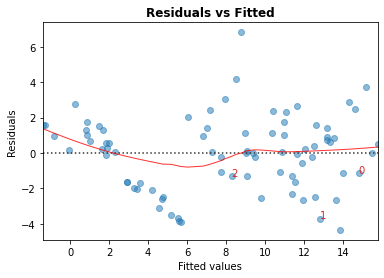

In [73]:
from utils import Linear_Reg_Diagnostic

diagnostics = Linear_Reg_Diagnostic(model)
diagnostics.residual_plot();


2. Q-Q plot
   - Also called a Quantile-Quantile plot. Plots our residuals against theoretical values. If the points on the plot roughly fall on the diagonal one-to-one line, our residuals are normally distributed. Otherwise, you may have non-normally distributed data. If so, consider transforming your data (or using a different type of model). 

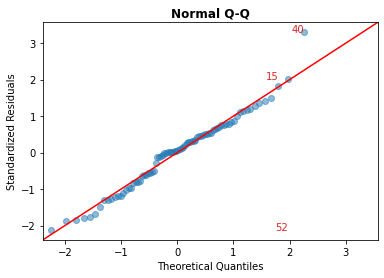

In [74]:
diagnostics.qq_plot();

3. Scale-location 
   - Similar to the residual vs fitted, we want to see a horizontal line, and equal spread across all of the fitted values. Consider transforming your data if one of these is not the case. 

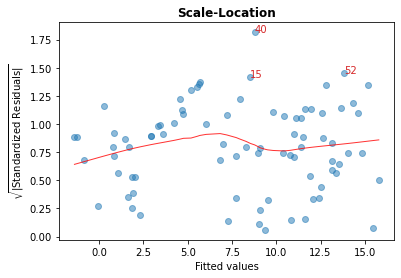

In [75]:
diagnostics.scale_location_plot();

4. Residuals vs Leverage
   - Used to detect outliers. If there are points well outside the red dotted lines (may not appear if you have no outliers) in the top or bottom right of the plot, you may consider removing these points from your analysis. 


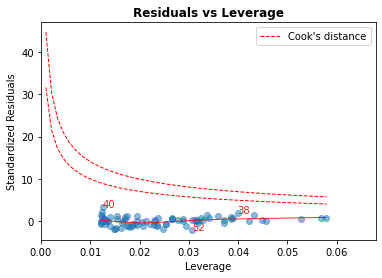

In [76]:
diagnostics.leverage_plot();

## Regression summary
When we check the summary of a linear model, we are presented with several lines of text. We are going to focus on the important parts of the table necessary for analysis. 

The second column has information about R-squared. R-squared is a measure of how much of the variance* in your data is explained by the model. It is a proportion, so it can be between 0 and 1. This row lists both Multiple R-squared and Adjusted R-squared. You should always use Adjusted R-squared for reasons covered later.

The F-statistic is a statistic measuring if there is a relationship between the predictors we have used and the dependent variable. The larger it is, the better, and a p-value ("Prob F-statistic") less than 0.05 suggests that the relationship is real. Again, technically, the p-value is the probability of seeing an F-statistic that large given your model and sample size if there is no relationship between $x$ and $y$. 

The summary also displays information about the $\beta$ coefficients. It lists the intercept ($\beta_0$) first, followed by the coefficient representing your independent variable ($\beta_1$). In the “Estimate” column, this is the actual fitted value of $\beta_0$ and $\beta_1$. 

The “std err” column is a measure of how precise this estimate is. The smaller the standard error is relative to the estimate is, the better.

Like t-tests, regressions also have t-values. Here, the t-values are the coefficient values divided by the standard error. The larger these values, the better, but the thresholds for what values we are looking for changes with our model and the sample size. 

Thankfully, the summary knows what these conditions are, and provides p-values “(Pr>|t|)” for us. P-values are probabilities. Here, they are the probability of getting the coefficient and standard error values we got if the true value were zero. For $\beta_1$, this is the probability that our coefficient estimate could have generated by a sample of the same size where x and y had no relationship or correlation. 

We call the situation where the true value of the coefficient is zero the null hypothesis. If the p-value is small, typically below 0.05, we reject the null hypothesis, and our data supports the alternative hypothesis that the value of the coefficient is not zero, and that the best estimate of its value is the estimate the model has made. 

*Note: variance is technically its own statistic, which can be calculated as the square of standard deviation.


In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             snow_total   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     438.9
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           3.21e-34
Time:                        13:37:27   Log-Likelihood:                -175.43
No. Observations:                  82   AIC:                             354.9
Df Residuals:                      80   BIC:                             359.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.1766      1.087     27.769      0.000      28.014      32.339
temp          -0.6095      0.029    -20.949      0.000      -0.667      -0.552
==============================================================================
Omnibus:                        1.296   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                0.725
Skew:                           0.148   Prob(JB):                        0.696
Kurtosis:                       3.353   Cond. No.                         177.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can take the coefficient our model estimated and use them to make our line. 

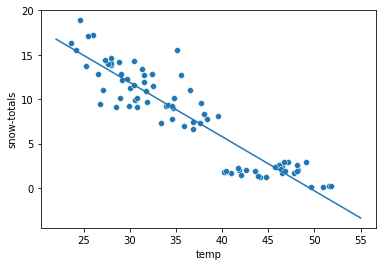

In [78]:
b0 = model.params[0]
b1 = model.params[1]

x = np.linspace(22, 55, 1000)
y = b0 + x*b1 

sns.scatterplot(data=df_sub, x='temp', y='snow-totals' )
sns.lineplot(x=x, y=y)
plt.show()

### Question

Work in groups. Using the gapminder dataset, create models predicting life expectancy with different numerical variables. Which columns give the highest R-squared values as predictors?

In [63]:
### your code
